# Pearson Correlation

Pearson Correlation의 공식은 다음과 같습니다.

$$ r = \frac{n \left( \sum xy \right) - \left( \sum x \right) \left( \sum y \right)}
{\sqrt{ \left[ n \sum x^2 - \left( \sum x \right)^2 \right]   
        \left[ n \sum y^2 - \left( \sum y \right)^2 \right] }} $$
        

In [84]:
%pylab inline

import pandas as pd
import numpy as np
from pony import orm
from pony.orm import select
from statsmodels import api as sm

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['select']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


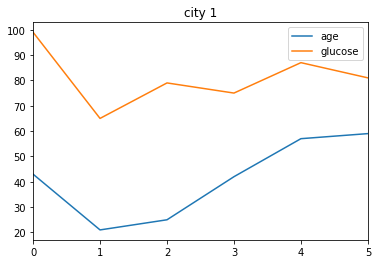

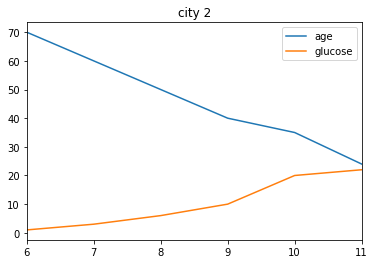

In [2]:
data = pd.DataFrame({'city': [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2],
                     'age': [43, 21, 25, 42, 57, 59, 70, 60, 50, 40, 35, 24], 
                     'glucose': [99, 65, 79, 75, 87, 81, 1, 3, 6, 10, 20, 22]})

city1 = data[data['city'] == 1]
city2 = data[data['city'] == 2]
city1.plot(y=['age', 'glucose'], title='city 1')
city2.plot(y=['age', 'glucose'], title='city 2')

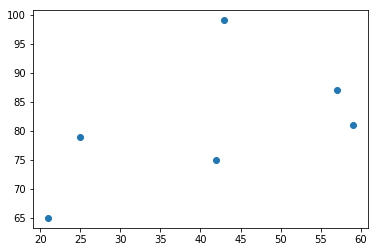

In [81]:
scatter(x=city1['age'], y=city1['glucose'])

## Numpy

In [3]:
def pearson_corr(x, y):
    N = len(x) 
    x_sum = np.sum(x)
    y_sum = np.sum(y)
    x_squared = np.sum(x**2)
    y_squared = np.sum(y**2)
    
    a = N * (np.sum(x * y)) - x_sum * y_sum
    b = (N * x_squared - x_sum**2) * (N * y_squared - y_sum**2)
    r = a / np.sqrt(b)
    
    return r
    
print('city1:', pearson_corr(city1['age'], city1['glucose']))
print('city2:', pearson_corr(city2['age'], city2['glucose']))

city1: 0.52980890189
city2: -0.945671421045


## Pandas

In [4]:
data.groupby('city').corr(method='pearson')

age   glucose
city                            
1    age      1.000000  0.529809
     glucose  0.529809  1.000000
2    age      1.000000 -0.945671
     glucose -0.945671  1.000000

## SQL 

먼저 pearson이라는 테이블을 만들고 데이터를 올립니다.

In [5]:
db = orm.Database()
db.bind(provider='postgres', user='postgres', password='1234', host='localhost', database='test')

# Create Table
class Pearson(db.Entity):
    id = orm.PrimaryKey(int, auto=True)
    city = orm.Required(int)
    age = orm.Required(int)
    glucose = orm.Required(int)
    
db.generate_mapping(create_tables=True)

# Insert Data
def insert_data(data):
    if Pearson.select().count():
        return None
        
    for i, d in data.iterrows():
        city = int(d.city)
        age = int(d.age)
        glucose = int(d.glucose)
        
        ent = Pearson(city=city, age=age, glucose=glucose)
        
    orm.commit()
    
insert_data(data)

Pony 에서는 다음과 같이 합니다.

In [91]:
def create_pearson_corr_query(x:str, y:str, x_on='id', y_on='id', group_by:list=[]):
    """
    @param x<str>: [table].[column]
    @param y<str>: [table].[column]
    @param x_on<str>: JOIN Column Name
    @param y_on<str>: JOIN Column Name
    """
    x_table, x_column = x.split('.')
    y_table, y_column = y.split('.')
    
    # GROUP BY
    group_columns = []
    group_sub_select = []
    group_select = []
    
    for i, g in enumerate(group_by):
        g_table, g_column = g.split('.')
        g_table = 'd1' if g_table == x_table else 'd2'
        group_columns.append(f'{g_table}.{g_column}')
        group_sub_select.append(f'{g_table}.{g_column} as name{i}')
        group_select.append(f'name{i}')
        
    group_columns = ', '.join(group_columns)
    group_sub_select = ', '.join(group_sub_select)
    group_select = ', '.join(group_select)
    
    group_by_sql = ''
    if group_columns:
        group_by_sql = f'GROUP BY {group_columns}'
        group_sub_select += ', '
        group_select += ', '
    
    query = '''SELECT {group_select}
(N * xy_psum - sum1 * sum2)/ 
    SQRT((N * sqsum1 - POW(sum1, 2)) * 
    (N * sqsum2 - POW(sum2, 2)))
FROM
    (SELECT {group_sub_select}
        COUNT(*) AS N,
        SUM(d1.{x} * d2.{y}) AS xy_psum,
        SUM(d1.{x}) AS sum1,
        SUM(d2.{y}) AS sum2,
        SUM(POW(d1.{x}, 2)) AS sqsum1,
        SUM(POW(d2.{y}, 2)) AS sqsum2
    FROM {x_table} AS d1
    LEFT JOIN {y_table} AS d2
    ON d1.{x_on} = d2.{y_on}
    {group_by_sql}) as pcorr
    '''.format(x_table=x_table, y_table=y_table, 
               x=x_column, y=y_column, 
               x_on=x_on, y_on=y_on, 
               
               group_select = group_select,
               group_sub_select= group_sub_select,
               group_by_sql=group_by_sql)
    return query
    
query = create_pearson_corr_query(x='pearson.age', y='pearson.glucose', group_by=['pearson.city'])
print(query)
db.select(query)

SELECT name0, 
(N * xy_psum - sum1 * sum2)/ 
    SQRT((N * sqsum1 - POW(sum1, 2)) * 
    (N * sqsum2 - POW(sum2, 2)))
FROM
    (SELECT d1.city as name0, 
        COUNT(*) AS N,
        SUM(d1.age * d2.glucose) AS xy_psum,
        SUM(d1.age) AS sum1,
        SUM(d2.glucose) AS sum2,
        SUM(POW(d1.age, 2)) AS sqsum1,
        SUM(POW(d2.glucose, 2)) AS sqsum2
    FROM pearson AS d1
    LEFT JOIN pearson AS d2
    ON d1.id = d2.id
    GROUP BY d1.city) as pcorr
    


[(1, 0.529808901890174), (2, -0.945671421044784)]

In [73]:
query = create_pearson_corr_query(x='pearson.age', y='pearson.glucose')
db.select(query)

[-0.204369399812033]